<a href="https://colab.research.google.com/github/nrajmalwar/EVA-6-Phase-1/blob/main/Session_05/Model_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target
1. Apply LR Scheduler using Lambda LR and a multiplicative factor of 0.85 ** epoch

# Result
1. Parameters - 9,436 (No change)
2. Best Train Acc - 99.05% (No change)
3. Best Test Acc - 99.53% (Increase)

# Analysis 
1. With LR Scheduler, target accuracy of 99.40%+ is achieved at 7th epoch and stays consistently.
2. Due to smaller learning rate in later epochs, accuracy bumps up to 99.53%.
3. Last 3 epochs have an average accuracy of 99.50%.
4. Changing batch size to 256 decreases the training time per epoch slightly by 1 second.


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
!pip install torchsummary
from torchsummary import summary

# Data Transformations - Adding Augmentations



In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-6.0, 6.0), fill=(33,)),
                                      transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      # Note the difference between (0.1307) and (0.1307,)
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The Model

In [5]:
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) 
          # output_size = 12, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12, RF = 6


        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8, RF = 14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF = 18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 4, RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1, RF = 28

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # No activation in last layer
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,512
              ReLU-6           [-1, 14, 24, 24]               0
       BatchNorm2d-7           [-1, 14, 24, 24]              28
         MaxPool2d-8           [-1, 14, 12, 12]               0
            Conv2d-9           [-1, 10, 12, 12]             140
           Conv2d-10           [-1, 14, 10, 10]           1,260
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
          Dropout-13           [-1, 14, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Model Training and Testing - LR Scheduler

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# LR Scheduler
lambda1 = lambda epoch: 0.85 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.014656812883913517 Batch_id=234 Accuracy=92.17: 100%|██████████| 235/235 [00:19<00:00, 11.79it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9871/10000 (98.71%)

EPOCH: 1


Loss=0.013492856174707413 Batch_id=234 Accuracy=97.76: 100%|██████████| 235/235 [00:19<00:00, 11.85it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9885/10000 (98.85%)

EPOCH: 2


Loss=0.010001967661082745 Batch_id=234 Accuracy=98.31: 100%|██████████| 235/235 [00:20<00:00, 11.71it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.09162674099206924 Batch_id=234 Accuracy=98.46: 100%|██████████| 235/235 [00:20<00:00, 11.66it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9924/10000 (99.24%)

EPOCH: 4


Loss=0.03818586468696594 Batch_id=234 Accuracy=98.59: 100%|██████████| 235/235 [00:20<00:00, 11.73it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.02528129331767559 Batch_id=234 Accuracy=98.72: 100%|██████████| 235/235 [00:20<00:00, 11.74it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

EPOCH: 6


Loss=0.014623264782130718 Batch_id=234 Accuracy=98.81: 100%|██████████| 235/235 [00:19<00:00, 11.76it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.03523479774594307 Batch_id=234 Accuracy=98.90: 100%|██████████| 235/235 [00:19<00:00, 11.93it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 8


Loss=0.04007599875330925 Batch_id=234 Accuracy=98.93: 100%|██████████| 235/235 [00:19<00:00, 11.85it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.008310316130518913 Batch_id=234 Accuracy=98.97: 100%|██████████| 235/235 [00:19<00:00, 11.79it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9950/10000 (99.50%)

EPOCH: 10


Loss=0.004331173840910196 Batch_id=234 Accuracy=99.05: 100%|██████████| 235/235 [00:20<00:00, 11.73it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9952/10000 (99.52%)

EPOCH: 11


Loss=0.038199618458747864 Batch_id=234 Accuracy=99.07: 100%|██████████| 235/235 [00:20<00:00, 11.73it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH: 12


Loss=0.06656255573034286 Batch_id=234 Accuracy=99.08: 100%|██████████| 235/235 [00:20<00:00, 11.59it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH: 13


Loss=0.002775030443444848 Batch_id=234 Accuracy=99.07: 100%|██████████| 235/235 [00:19<00:00, 11.77it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9953/10000 (99.53%)

EPOCH: 14


Loss=0.0334785170853138 Batch_id=234 Accuracy=99.10: 100%|██████████| 235/235 [00:20<00:00, 11.69it/s]



Test set: Average loss: 0.0165, Accuracy: 9949/10000 (99.49%)



# Accuracy and Loss graphs

Text(0.5, 1.0, 'Test Accuracy')

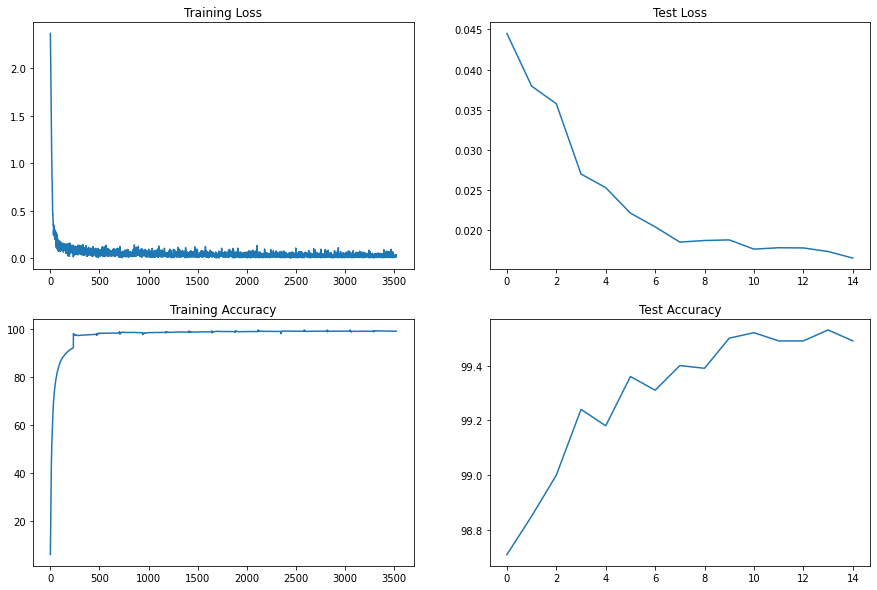

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Misclassified Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


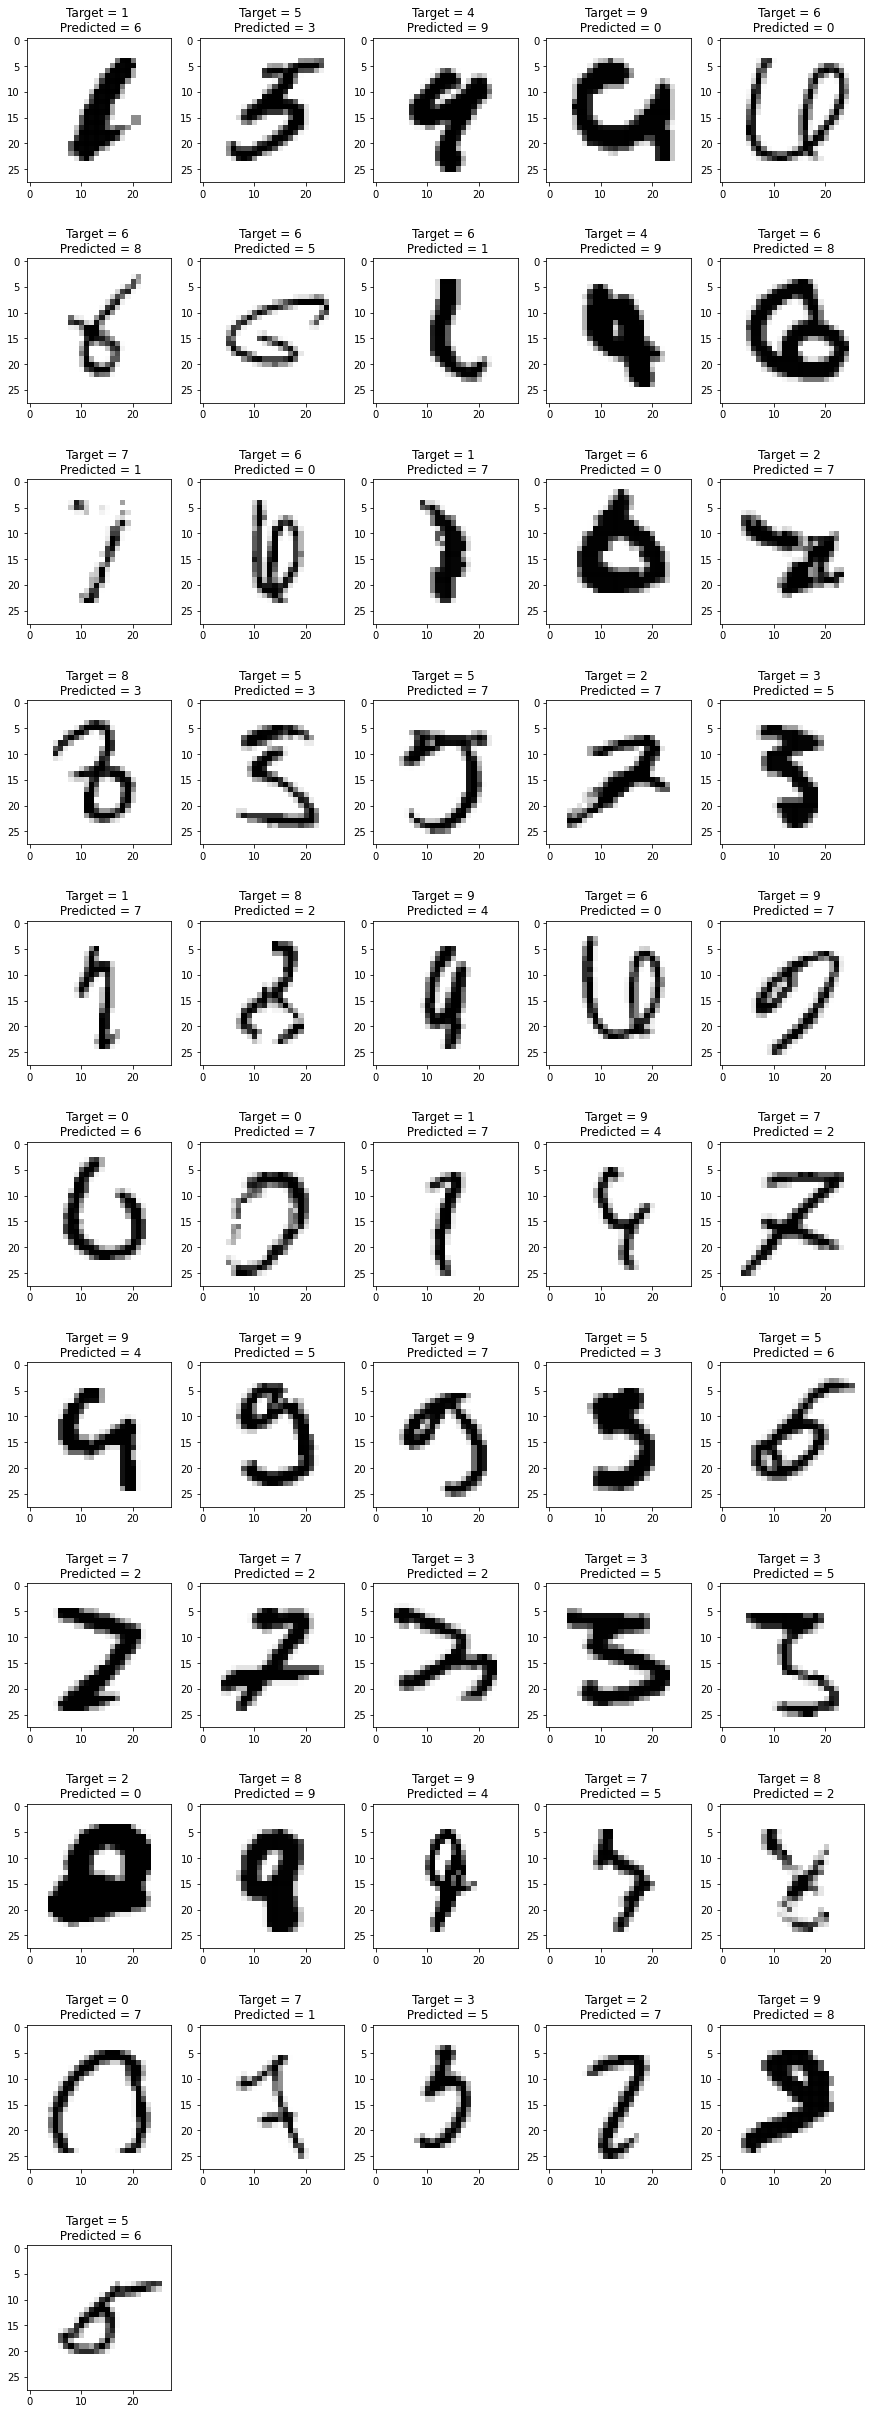

In [10]:
model.eval()

# Create a test loader with batch size equal to test data length
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=len(test), num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=len(test))
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        # Get the indexes of images that are incorrectly classified
        indexes = (pred.view(-1,) != target.view(-1,)).nonzero()

        # Plot the misclassified images
        rows = np.ceil(len(indexes)/5)
        fig = plt.figure(figsize=(15, rows*4))
        for i, idx in enumerate(indexes):
            ax = fig.add_subplot(rows, 5, i+1)
            ax.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray_r')
            ax.set_title(f"Target = {target[idx].item()} \n Predicted = {pred[idx].item()}")
        
        plt.show()